In [1]:
import sys
sys.path.insert(0, "/home/storage/hans/jax_reco")

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

from lib.simdata_i3 import I3SimHandlerFtr
from lib.plotting import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track
from time_sampler import sample_times_clean

from palettable.cubehelix import Cubehelix
cx = Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()


2024-06-03 12:26:42.820180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


muon energy: 2.1 TeV
n_doms 29


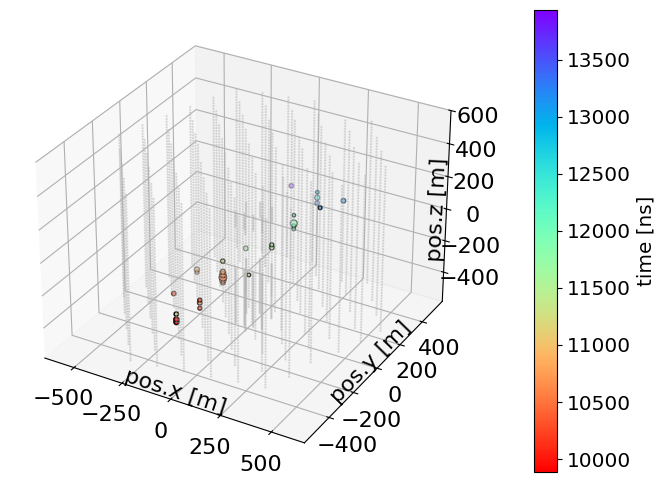

In [250]:
# Event Index.
event_index = 0

# Random number seed.
key = jax.random.PRNGKey(event_index)

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Produce and save an event view.
plot_event(event_data, geo=sim_handler.geo)


In [251]:
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

old track vertex: [-1277.51128861 -1390.39564543 -1675.98024553]
new track vertex: [ -53.74394146  162.12452256 -233.73599134]


In [252]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.column_stack([
                                        jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy()),
                                        jnp.array(n_photons)
                                   ])


In [253]:
from lib.cgamma import c_multi_gamma_prob_v

In [254]:
def get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track_fn, 
                                            eps=jnp.float64(1.e-20), 
                                            dtype=jnp.float64):

    @jax.jit
    def neg_c_triple_gamma_llh_const_vertex(track_direction, 
                                            track_vertex, 
                                            track_time, 
                                            event_data):
        dom_pos = event_data[:, :3]
        first_hit_times = event_data[:, 3]
        logits, av, bv, geo_time = eval_network_doms_and_track_fn(dom_pos, track_vertex, track_direction)

        mix_probs = jax.nn.softmax(logits)
        delay_time = first_hit_times - (geo_time + track_time)
    
        sigma = 3.0
        delta = 10.0
        return -2.0 * jnp.sum(jnp.log(c_multi_gamma_prob_v(delay_time, 
                                                           mix_probs,
                                                           av,
                                                           bv,
                                                           sigma,
                                                           delta)))

    return neg_c_triple_gamma_llh_const_vertex
    

In [255]:
neg_llh = get_neg_c_triple_gamma_llh_const_vertex(eval_network_doms_and_track)

In [256]:
# And do a minimization.
@jax.jit
def minimize(x0):
    return optimize.minimize(neg_llh, 
                             x0, 
                             args=(centered_track_pos,
                                    centered_track_time,
                                    fitting_event_data), 
                             method="BFGS", 
                             tol=1.e-5)

result_bfgs = minimize(track_src)
print(result_bfgs)

OptimizeResults(x=Array([2.20539562, 4.04123066], dtype=float64), success=Array(False, dtype=bool), status=Array(3, dtype=int64, weak_type=True), fun=Array(345.09120304, dtype=float64), jac=Array([-0.00176224,  0.00153838], dtype=float64), hess_inv=Array([[8.50270220e-06, 1.91423816e-06],
       [1.91423816e-06, 1.03555603e-05]], dtype=float64), nfev=Array(58, dtype=int64, weak_type=True), njev=Array(58, dtype=int64, weak_type=True), nit=Array(11, dtype=int64, weak_type=True))


In [257]:
# And do a minimization.
@jax.jit
def minimize(x0):
    return optimize.minimize(neg_llh, 
                             x0, 
                             args=(centered_track_pos,
                                    centered_track_time,
                                    fitting_event_data), 
                             method="l-bfgs-experimental-do-not-rely-on-this", 
                             tol=1.e-5)

result_lbfgs = minimize(track_src)
print(result_lbfgs)

OptimizeResults(x=Array([2.20539562, 4.04123066], dtype=float64), success=Array(True, dtype=bool), status=Array(0, dtype=int64, weak_type=True), fun=Array(345.09120304, dtype=float64), jac=Array([-4.38443962e-07,  5.56547992e-07], dtype=float64), hess_inv=None, nfev=Array(24, dtype=int64, weak_type=True), njev=Array(24, dtype=int64, weak_type=True), nit=Array(7, dtype=int64, weak_type=True))


In [258]:
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))

347.80020840454387


In [259]:
neg_llh_v = jax.jit(jax.vmap(neg_llh, (0, None, None, None), 0))

In [260]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

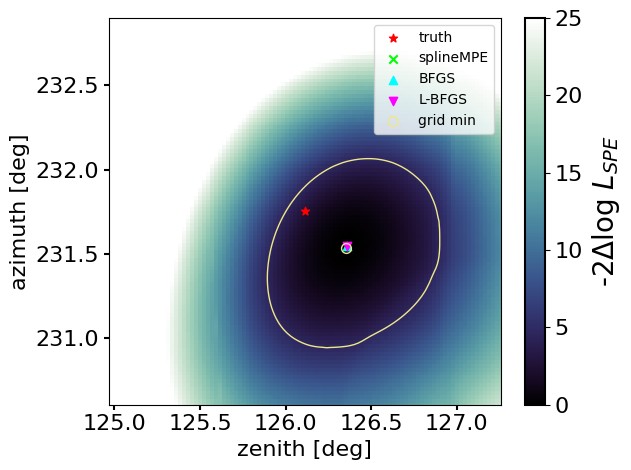

TriplePandelSPE: 0.3009180465326773
SplineMPE: 1.3853546375668764


In [261]:
# And plot likelihood space.
n_eval = 100
zenith = np.linspace(track_src[0]-0.02, track_src[0]+0.02, n_eval)
azimuth = np.linspace(track_src[1]-0.02, track_src[1]+0.02, n_eval)
X, Y = np.meshgrid(zenith, azimuth)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-0.02, track_src[0]+0.02]))
ax.set_ylim(np.rad2deg([track_src[1]-0.02, track_src[1]+0.02]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

#b_zenith = result.x[0]
#b_azimuth = result.x[1]
#ax.scatter(np.rad2deg([b_zenith]), np.rad2deg([b_azimuth]), marker="x", color='lime', label='2D-fit')

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = result_bfgs.x[0]
azimuth = result_bfgs.x[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='^', color='cyan', label='BFGS')

zenith = result_lbfgs.x[0]
azimuth = result_lbfgs.x[1]
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='v', color='magenta', label='L-BFGS')

# generate contours
contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()


print("TriplePandelSPE:", np.squeeze(np.rad2deg(GreatCircleDistance(track_src[1], track_src[0], Y[ix1, ix2], X[ix1, ix2]))))
print("SplineMPE:", np.rad2deg(GreatCircleDistance(track_src[1], track_src[0], smpe_azimuth, smpe_zenith)))

In [262]:
#%timeit neg_llh_v(init_dirs, centered_track_pos, centered_track_time, fitting_event_data)

In [263]:
print(first_times)

[11191.  9955.  9887. 10276. 10153. 10744. 10150. 10908. 10760. 11195.
 10741. 10592. 10535. 10529. 10826. 11231. 11605. 11605. 11528. 12409.
 11896. 11952. 12015. 13220. 13935. 12888. 12555. 13247. 13107.]


In [264]:
dom_pos = fitting_event_data[:, :3]
first_hit_times = fitting_event_data[:, 3]
logits, av, bv, geo_time = eval_network_doms_and_track(dom_pos, 
                                                                  centered_track_pos, 
                                                                  track_src)

mix_probs = jax.nn.softmax(logits)
delay_time = first_hit_times - (geo_time + centered_track_time)

In [265]:
print(delay_time)

[ 1.26175291e+03  1.35378298e+02  1.13837959e+02  2.16194666e+02
  2.73319198e+01  6.48844400e+02  7.60605136e+01  2.75608608e+02
  1.83191679e+02  2.45111754e+02  8.27903984e+01  4.41016058e+00
  3.71064588e-01 -5.86785361e-01  2.91929228e+02  1.48031922e+02
  3.90630254e+02  6.12122454e+01  2.33031617e+01  3.02426662e+02
  5.45519777e+00  7.99021036e+01  1.37627341e+02  5.68037094e+02
  1.23471874e+03  2.71021896e+02  5.10275213e+01  8.04590794e+02
  2.59201683e+02]


In [266]:
print(meta)

event_id                   2.121703e+09
idx_start                  0.000000e+00
idx_end                    4.600000e+01
n_channel_HLC              2.100000e+01
neutrino_energy            4.722192e+04
muon_energy                3.391497e+04
muon_energy_at_detector    2.139244e+03
muon_energy_lost           8.823812e+02
q_tot                      4.357500e+01
n_channel                  2.900000e+01
muon_zenith                2.201092e+00
muon_azimuth               4.044857e+00
muon_time                  3.002587e+03
muon_pos_x                -1.277511e+03
muon_pos_y                -1.390396e+03
muon_pos_z                -1.675980e+03
spline_mpe_zenith          2.224013e+00
spline_mpe_azimuth         4.035248e+00
spline_mpe_time            1.088498e+04
spline_mpe_pos_x          -9.655990e+01
spline_mpe_pos_y           1.078559e+02
spline_mpe_pos_z          -2.819733e+02
Name: 0, dtype: float64
